In [5]:
import pandas as pd 

dep_mappings="""SBV	主谓关系	subject-verb	我送她一束花 (我 <-- 送)
VOB	动宾关系	直接宾语，verb-object	我送她一束花 (送 --> 花)
IOB	间宾关系	间接宾语，indirect-object	我送她一束花 (送 --> 她)
FOB	前置宾语	前置宾语，fronting-object	他什么书都读 (书 <-- 读)
DBL	兼语	double	他请我吃饭 (请 --> 我)
ATT	定中关系	attribute	红苹果 (红 <-- 苹果)
ADV	状中结构	adverbial	非常美丽 (非常 <-- 美丽)
CMP	动补结构	complement	做完了作业 (做 --> 完)
COO	并列关系	coordinate	大山和大海 (大山 --> 大海)
POB	介宾关系	preposition-object	在贸易区内 (在 --> 内)
LAD	左附加关系	left adjunct	大山和大海 (和 <-- 大海)
RAD	右附加关系	right adjunct	孩子们 (孩子 --> 们)
IS	独立结构	independent structure	两个单句在结构上彼此独立
WP	标点符号	punctuation	标点符号
HED	核心关系	head	指整个句子的核心"""

def to_df(list_of_tuples, columns):
    return pd.DataFrame(list_of_tuples, columns=columns)

def fix_desc(desc):
    if '，' in desc:
        desc=desc.split('，')[1]
    return desc.replace('-','_').replace(' ','_')

rows=[]
dep_map={}
for el in dep_mappings.split('\n'):
    parts=el.split('\t')
    depname=fix_desc(parts[2])
    rows.append((parts[0], depname, "[%s]"%parts[1], parts[3]))
    dep_map[parts[0]]=(depname, parts[1])
to_df(rows, ['abbrev', 'name', 'zh', 'example'])    

,abbrev,name,zh,example
0,SBV,subject_verb,[主谓关系],我送她一束花 (我 <-- 送)
1,VOB,verb_object,[动宾关系],我送她一束花 (送 --> 花)
2,IOB,indirect_object,[间宾关系],我送她一束花 (送 --> 她)
3,FOB,fronting_object,[前置宾语],他什么书都读 (书 <-- 读)
4,DBL,double,[兼语],他请我吃饭 (请 --> 我)
5,ATT,attribute,[定中关系],红苹果 (红 <-- 苹果)
6,ADV,adverbial,[状中结构],非常美丽 (非常 <-- 美丽)
7,CMP,complement,[动补结构],做完了作业 (做 --> 完)
8,COO,coordinate,[并列关系],大山和大海 (大山 --> 大海)
9,POB,preposition_object,[介宾关系],在贸易区内 (在 --> 内)


In [6]:
import sys

from google.protobuf.json_format import MessageToJson
from client_wrapper import ServiceClient

import nlpserv_pb2 as nlp_messages
import nlpserv_pb2_grpc as nlp_service
from utils import dump

client=ServiceClient(nlp_service, 'NlpProcsStub', 'localhost', 10052)
def deps(text):
    request = nlp_messages.NlTexts(texts=[nlp_messages.NlText(text=text)])
    response = client.GetDependencyGraph(request)
    return response

def deps_df(text):
    response=deps(text)
    rows=[]
    for t in response.words:
        # print(MessageToJson(resp))
        rows.append((t.lemma, dep_map[t.deprel][0],
                     dep_map[t.deprel][1],
                     t.head))
    return to_df(rows, ['lemma', 'dep', 'dep_t', 'head'])

In [7]:
deps_df("这里是北京")

,lemma,dep,dep_t,head
0,这里,subject_verb,主谓关系,是
1,是,head,核心关系,##核心##
2,北京,verb_object,动宾关系,是


In [24]:
deps_df("徐先生还具体帮助他确定了把画雄鹰、松鼠和麻雀作为主攻目标。")

,lemma,dep,dep_t,head
0,徐先生,subject_verb,主谓关系,帮助
1,还,adverbial,状中结构,帮助
2,具体,adverbial,状中结构,帮助
3,帮助,head,核心关系,##核心##
4,他,double,兼语,帮助
5,确定,verb_object,动宾关系,帮助
6,了,right_adjunct,右附加关系,确定
7,把,adverbial,状中结构,作为
8,画,preposition_object,介宾关系,把
9,雄鹰,verb_object,动宾关系,画


徐先生 --[主谓关系](SBV)--> 帮助
还 --[状中结构](ADV)--> 帮助
具体 --[状中结构](ADV)--> 帮助
帮助 --[核心关系](HED)--> ##核心##
他 --[兼语](DBL)--> 帮助
确定 --[动宾关系](VOB)--> 帮助
了 --[右附加关系](RAD)--> 确定
把 --[状中结构](ADV)--> 作为
画 --[介宾关系](POB)--> 把
雄鹰 --[动宾关系](VOB)--> 画
、 --[标点符号](WP)--> 松鼠
松鼠 --[并列关系](COO)--> 雄鹰
和 --[左附加关系](LAD)--> 麻雀
麻雀 --[并列关系](COO)--> 雄鹰
作为 --[动宾关系](VOB)--> 确定
主攻 --[定中关系](ATT)--> 目标
目标 --[动宾关系](VOB)--> 作为
。 --[标点符号](WP)--> 帮助


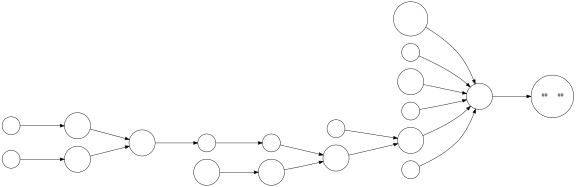

In [39]:
class HanlpProtoViz(object):
    def __init__(self):
        from graphviz import Digraph
        self.f = Digraph('deps', filename='deps.gv')
        self.f.attr(rankdir='LR', size='8,5')
        self.f.attr('node', shape='circle')

    def print_dependencies(self, doc, segs, file=None):
        for word in doc.words:
            print("%s --[%s](%s)--> %s" % (word.lemma, 
                                           dep_map[word.deprel][1],
                                           word.deprel, word.head))
            self.f.edge(word.lemma, word.head, 
                        label=dep_map[word.deprel][1])

    def analyse(self, sents):
        segs = []
        response=deps(sents)
        for word in response.words:
            self.f.node(word.lemma)
            segs.append(word.lemma)
        self.print_dependencies(response, segs)
        return self.f

HanlpProtoViz().analyse('徐先生还具体帮助他确定了把画雄鹰、松鼠和麻雀作为主攻目标。')

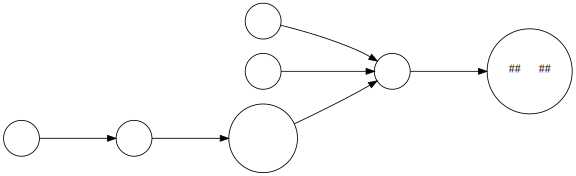

In [42]:
from sagas.bots.hanlp_viz import HanlpProtoViz
HanlpProtoViz(verbose=False).analyse('我要找一本英语书')

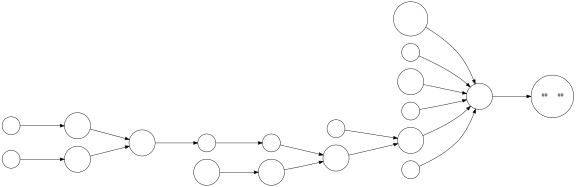

In [43]:
HanlpProtoViz(verbose=False).analyse('徐先生还具体帮助他确定了把画雄鹰、松鼠和麻雀作为主攻目标。')

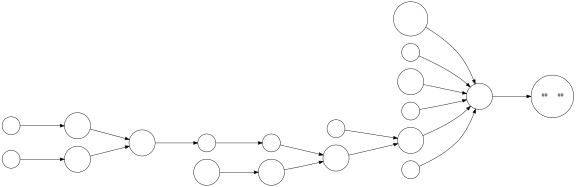

In [44]:
g=HanlpProtoViz(verbose=False).analyse('徐先生还具体帮助他确定了把画雄鹰、松鼠和麻雀作为主攻目标。')
display(g)

In [2]:
from client_wrapper import ServiceClient

import nlpserv_pb2 as nlp_messages
import nlpserv_pb2_grpc as nlp_service
from utils import dump

client=ServiceClient(nlp_service, 'NlpProcsStub', 'localhost', 10052)
def get_deps(text):
    request = nlp_messages.NlTexts(texts=[nlp_messages.NlText(text=text)])
    response = client.GetDependencyGraph(request)
    return response

def disp_deps(text):
    response=get_deps(text)
    for k,v in response.coreGraph.items():
        print(k,v)

disp_deps('徐先生还具体帮助他确定了把画雄鹰、松鼠和麻雀作为主攻目标。')

zh_SBV xu xian sheng
zh_VOB|text 确定
zh_VOB@zh 确定
zh_VOB|head 帮助
zh_VOB|id 6
zh_SBV|text 未##人
zh_SBV@zh 徐先生
zh_SBV|head 帮助
zh_SBV|id 1
zh_VOB|head_id 4
zh_VOB que ding
zh_SBV|head_id 4


In [33]:
from natasha.markup import format_markup_css
class Matches(object):
    __attributes__ = ['text', 'matches']

    def __init__(self, text, matches, attrs=['nr']):
        self.text = text
        # self.matches = sorted(matches, key=lambda _: _.span)
        # self.matches = sorted(r.entities, key=lambda _: _.start)
        self.matches=matches
        self.attrs=attrs

    def __iter__(self):
        return iter(self.matches)

    def __getitem__(self, index):
        return self.matches[index]

    def __len__(self):
        return len(self.matches)

    def __bool__(self):
        return bool(self.matches)

    @property
    def as_json(self):
        return [serialize(_) for _ in self.matches]

    def _repr_html_(self):
        spans = [(_.start,_.end) for _ in self.matches
                 if _.entity in self.attrs
                ]
        return ''.join(format_markup_css(self.text, spans))

In [34]:
from google.protobuf.json_format import MessageToJson
from client_wrapper import ServiceClient

import nlpserv_pb2 as nlp_messages
import nlpserv_pb2_grpc as nlp_service
from utils import dump

client=ServiceClient(nlp_service, 'NlpProcsStub', 'localhost', 10052)
def extract(text):
    request = nlp_messages.NlTokenizerRequest(text=nlp_messages.NlText(text=text))
    response = client.EntityExtractor(request)
    return response

r=extract('徐先生帮助他确定')
# print(r)
# for el in r.entities:
#     print(el.start)
matches = sorted(r.entities, key=lambda _: _.start)
for el in matches:
    print(el.start, el.end, el.value, el.entity)
spans = [(_.start,_.end) for _ in matches]
for span in spans:
    start, stop = span
    print(start,stop)

0 3 徐先生 nr
3 5 帮助 v
5 6 他 r
6 8 确定 v
0 3
3 5
5 6
6 8


In [36]:
text='徐先生帮助他确定'
r=extract(text)
matches = sorted(r.entities, key=lambda _: _.start)
Matches(text, matches)

In [37]:
display(Matches(text, matches))